# Fine-grained Twitter Account Classification based on BLOC with Ensemble Modeling

### Content

01. [Datasets](#Used-datasets:)
02. [Step 01: Preprocessing](#STEP-01:-DATA-PREPROCESSING)
03. [Step 02: Feature Extraction](#STEP-02:-FEATURE-EXTRACTION)
04. [Step 03: Feature Selection](#STEP-03:-FEATURE-SELECTION)
05. [Step 04: Classification](#STEP-04:-CLASSIFICATION)  
06. [Step 05: Evaluation](#STEP-05---EVALUATION)


![Sample Image](resources/Design.jpg)





## Datasets: 

| Account Name           | Bot Type                   | Count    | Human Type           |Count    |
|------------------------|----------------------------|----------|----------------------|---------|
| astroturf              | political_Bot              | 585      |                      |         |
| josh_political         | political_Bot              | 62       |                      |         |
| cresci-17              | bot-socialspam             | 4912     |                      |         |
|                        | bot-fakefollower           | 3351     |                      |         |
|                        | bot-traditionspam          | 2631     |                      |         |
| verified               |                            |          | verified_account     | 2000    |
| stock                  | financial_bot              | 18508    | financial_account    | 7479    |
| pronbots               | Adult Content_scam         | 21964    |                      |         |
| caverlee               | content_polluters          | 22179    | Legit_human          | 19276   |
| botwiki                | selfidentified_bot         | 704      |                      |         |
| midterm-2018           |                            |          | political_account    | 8092    |
| gregory_purchased      | fake_follwers              | 1088     |                      |         |
| **Total**              |                            |**75984** |                      |**36847**|

**Bot labels:** political_Bot, bot-socialspam, bot-traditionspam, bot-fakefollower, financial_bot, adult_content_scam, content_polluters

**Human Labels:** Legit_human, verified_account, financial_account, political_account

[Classification classes with description](https://docs.google.com/document/d/1FnsCqGkv92D109rlaY9yqq1diApRwsQfFHAfw22WHc8/edit?usp=sharing)


## STEP 01: DATA PREPROCESSING

In [1]:
import json
import csv
import gzip

from bloc.generator import add_bloc_sequences
from bloc.util import conv_tf_matrix_to_json_compliant
from bloc.util import get_bloc_variant_tf_matrix
from bloc.util import get_default_symbols
from bloc.util import getDictFromJson
from bloc.util import get_bloc_params

bot_dataset_files = [
    {'src': 'astroturf', 'classes': ['political_Bot']}, #political_Bot
    {'src': 'botwiki', 'classes': ['bot']}, #selfidentified_Bot
    {'src': 'caverlee', 'classes': ['human', 'bot']}, #content_polluters, #Legit_human
    {'src': 'cresci-17', 'classes': ['human', 'bot-socialspam', 'bot-traditionspam', 'bot-fakefollower']},
    {'src': 'gregory_purchased', 'classes': ['bot']}, #bot-fakefollower
    {'src': 'josh_political', 'classes': ['bot']}, #political_Bot
    {'src': 'midterm-2018', 'classes': ['human']}, #political_account
    {'src': 'pronbots', 'classes': ['bot']}, #adult_Content_Scam
    {'src': 'stock', 'classes': ['human', 'bot']}, #financial_bot, #financial_account
    {'src': 'verified', 'classes': ['human']} #verified_account
    # {'src': 'gilani-17', 'classes': ['human', 'bot']},
    # {'src': 'kevin_feedback', 'classes': ['human', 'bot']},
    # {'src': 'rtbust', 'classes': ['human', 'bot']},
    # {'src': 'varol-icwsm', 'classes': ['bot', 'human']},
    # {'src': 'zoher-organization', 'classes': ['human', 'organization']}
]

In [2]:
# Read UserId.txt file, and add it to a map

def get_user_id_class_map(file_path):
    
    user_id_class_map = {}
    all_classes = set()

    with open(file_path, 'r') as fd:
        for line in fd:
            parts = line.strip().split()
            if len(parts) >= 2:
                user_id, user_class = parts[0], parts[1]
                user_id_class_map[user_id] = user_class
                all_classes.add(user_class)

    return user_id_class_map, all_classes

# Return each twitter account into a bloc doc

def get_bloc_doc(u_bloc, bloc_model, user_id_class):

    doc = [u_bloc['bloc'][dim] for dim in bloc_model['bloc_alphabets'] if dim in u_bloc['bloc']]
    doc = ''.join(doc)
    doc = doc.strip()
    return {
        'text': doc,
        'user_id': u_bloc['user_id'],
        'screen_name': u_bloc['screen_name'],
        'src': 'IU',
        'class': user_id_class
    }

In [4]:
all_bloc_symbols = get_default_symbols()
gen_bloc_params, gen_bloc_args = get_bloc_params([], '', sort_action_words=True,
                                                 keep_bloc_segments=True,
                                                 tweet_order='noop')
bloc_model = {
    'name': 'm1: bigram',
    'ngram': 2,
    'token_pattern': '[^ |()*]',
    'tf_matrix_norm': 'l1',  # set to '' if tf_matrices['tf_matrix_normalized'] not needed
    'keep_tf_matrix': True,
    'set_top_ngrams': True,
    'top_ngrams_add_all_docs': True,
    'bloc_variant': None,
    'bloc_alphabets': ['action', 'content_syntactic']
}

bloc_doc_lst = []
dataset_path = '../dataset/'
for file in bot_dataset_files:
    tweets_file_path = dataset_path + file['src'] + '/tweets.jsons.gz'
    userid_file_path = dataset_path + file['src'] + '/userIds.txt'
    user_id_class_map, all_classes = get_user_id_class_map(userid_file_path)
    with gzip.open(tweets_file_path, 'rt', encoding='windows-1252') as infile:
        for line in infile:
            line = line.split('\t')
            if user_id_class_map.get(line[0], '') in file['classes']:
                tweets = getDictFromJson(line[1])
                u_bloc = add_bloc_sequences(tweets, all_bloc_symbols=all_bloc_symbols, **gen_bloc_params)
                user_class = user_id_class_map.get(line[0], '')
                if file['src'] == 'botwiki':
                    user_class = 'selfidentified_Bot'
                elif file['src'] == 'caverlee' and user_id_class_map.get(line[0], '') == 'bot':
                    user_class = 'content_polluters'
                elif file['src'] == 'caverlee' and user_id_class_map.get(line[0], '') == 'human':
                    user_class = 'legit_human'
                elif file['src'] == 'cresci-17' and user_id_class_map.get(line[0], '') == 'human':
                    user_class = 'legit_human'
                elif file['src'] == 'gregory_purchased':
                    user_class = 'bot-fakefollower'
                elif file['src'] == 'josh_political':
                    user_class = 'political_Bot'
                elif file['src'] == 'midterm-2018':
                    user_class = 'political_account'
                elif file['src'] == 'pronbots':
                    user_class = 'adult_content_Scam'
                elif file['src'] == 'stock' and user_id_class_map.get(line[0], '') == 'bot':
                    user_class = 'financial_bot'
                elif file['src'] == 'stock' and user_id_class_map.get(line[0], '') == 'human':
                    user_class = 'financial_account'
                elif file['src'] == 'verified':
                    user_class = 'verified_account'
                bloc_doc_lst.append(get_bloc_doc(u_bloc, bloc_model, user_class))

In [5]:
bloc_doc_lst[0]

{'text': 'r□rrr□r⚁p⚀pr□r□rrrrrrrrrrrrrr□rrrr□pr□pr□r⚁rrr⚀r□r⚁pr⚀pr⚀prrrrrr□pprrrrrrr□prrrr□ppppprrrrrrrrrrrrr□r□r□r⚁rr⚀T⚀r⚁p□r⚀T⚁p□pr⚀rr⚁rrrrrrrrrrr□prrrrrrr⚀rr□r⚁p□pp□ppppprrrrrr⚀prr⚁p□rr□prr⚀r⚀T⚀rr⚀rrrr□ppprrrrrrrrrrrr□pppppppppppppprrrrrrrrrrrrrr□pr⚀pprr | r⚁r⚁r□ρ⚁r⚀r⚀r□r□r⚀r⚁r⚀r⚀r⚁r□r⚀r⚀r□r□r□r⚀r⚀r□pr⚀r⚀r⚀r⚀r⚀r⚀r⚀r□r□rr⚀p⚀r⚀r⚀r⚀r⚀r⚀p⚀rr⚁r⚀p□r⚁r□p⚀r□p□r⚀r□r⚀pr□r⚀r⚀r⚀r⚀pr⚀r□r□rr□p⚀r⚀r⚀r⚀r□r□r□r□p⚀r□r□p (mt)(t)(Em)(mt)(mmqt)(qt)(qt)(t)(Et)(qt)(qt)(qt)(qt)(qt)(Hqt)(qt)(qt)(t)(t)(t)(qt)(qt)(Emqt)(qt)(qt)(qt)(qt)(mt)(t)(Hmqt)(mmqt)(mt)(mt)(t)(t)(qt)(mmqt)(Et)(qt)(Et)(Ut)(EHHt)(mmt)(t)(EHt)(mt)(t)(E)(qt)(Eqt)(t)(qt)(mUt)(HmUt)(Ut)(mqt)(t)(qt)(Emt)(mqt)(Hqt)(EHt)(t)(Ut)(Ut)(Hqt)(EH)(Ut)(qt)(Et)(qt)(Et)(EHt)(HHmUt)(Emt)(mqt)(H)(mqt)(qt)(Emt)(mUt)(mt)(Ut)(HHHHqt)(qt)(qt)(HHHqt)(mt)(qt)(EEt)(mmqt)(t)(qt)(mmmqt)(qt)(Ut)(qt)(qt)(qt)(Ut)(Ut)(qt)(qt)(mmmqt)(Et)(Ut)(t)(qt)(qt)(Et)(mmU)(Et)(qt)(qt)(qt)(mmmmmmmqt)(E)(mmmmmmmmqt)(mmmmmmmqt)(mmmmmmmqt)(mmmmmmmqt)(mmmmmmmmqt)(mmmmmmmmqt)(mmmmmmmmqt)(mm

## STEP 02: FEATURE EXTRACTION

In [7]:
import pandas as pd
import numpy as np

tf_matrix = get_bloc_variant_tf_matrix(bloc_doc_lst,
                                       tf_matrix_norm=bloc_model['tf_matrix_norm'],
                                       keep_tf_matrix=bloc_model['keep_tf_matrix'],
                                       min_df=2,
                                       ngram=bloc_model['ngram'],
                                       token_pattern=bloc_model['token_pattern'],
                                       bloc_variant=bloc_model['bloc_variant'],
                                       set_top_ngrams=bloc_model.get('set_top_ngrams', False),
                                       top_ngrams_add_all_docs=bloc_model.get('top_ngrams_add_all_docs', False))

with gzip.open('results/tf_idf_matrices-2.json.gz', 'wt', encoding='utf-8') as json_gz_file:
    json.dump(conv_tf_matrix_to_json_compliant(tf_matrix), json_gz_file, indent=2)

csv_file_path = 'results/features-2.csv'

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    header = ['user_id', 'class'] + [f'tf_vector_{i}' for i in
                                     range(len(tf_matrix['tf_matrix_normalized'][0]['tf_vector']))]
    writer.writerow(header)

    for entry in tf_matrix['tf_matrix']:
        row = [entry['user_id'], entry['class']] + entry['tf_vector']
        writer.writerow(row)

feature_df = pd.read_csv('results/features-2.csv')
feature_df.head()

,user_id,class,tf_vector_0,tf_vector_1,tf_vector_2,tf_vector_3,tf_vector_4,tf_vector_5,tf_vector_6,tf_vector_7,...,tf_vector_183,tf_vector_184,tf_vector_185,tf_vector_186,tf_vector_187,tf_vector_188,tf_vector_189,tf_vector_190,tf_vector_191,tf_vector_192
0,1.106326e+18,political_Bot,1.0,5.0,0.0,9.0,2.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.162760e+18,political_Bot,1.0,1.0,1.0,8.0,2.0,12.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.120465e+17,political_Bot,7.0,3.0,2.0,2.0,4.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.186273e+17,political_Bot,2.0,0.0,0.0,3.0,2.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.112680e+09,political_Bot,4.0,4.0,2.0,15.0,0.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## STEP 03: FEATURE SELECTION

In [8]:
print("Start to load the features")
feature_df = pd.read_csv('results/features.csv')

print(f"Shuffle the features of {len(feature_df)} samples")
feature_df = feature_df.sample(frac=1)

X_df = feature_df.drop(columns = ['class','user_id'])
x = np.array(X_df)

y = feature_df['class'].values
y_names = np.unique(feature_df['class'].values)

Start to load the features
Shuffle the features of 83652 samples


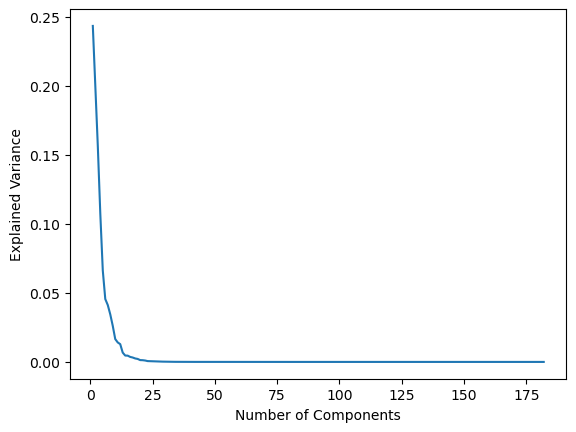

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()

pca.fit(x)  
explained_variance = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [12]:
pca=PCA(n_components=25)
x1 = pca.fit_transform(x)

## STEP 04: CLASSIFICATION

In [13]:
from sklearn.model_selection import train_test_split as tts

Xtrain,Xtest,ytrain,ytest = tts(x1, y, test_size=0.25, random_state=1693)

### Step 04 - a) Hyperparameter Optimization

In [15]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC

param_grid = dict(n_estimators=[150, 200, 250],max_depth = [15, 30, 45],
                 min_samples_split = [5, 10, 15])

cv = KFold(n_splits=10, random_state=146, shuffle = True)

grid = GridSearchCV(RFC(random_state = 146), param_grid=param_grid, cv=cv, 
                    scoring='accuracy')
grid.fit(Xtrain, ytrain)

print(f'The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}')

The best parameters are {'max_depth': 45, 'min_samples_split': 5, 'n_estimators': 200} with a score of 0.77


In [ ]:
results = pd.DataFrame(grid.cv_results_)[['param_n_estimators','param_max_depth', 
                                          'param_min_samples_split','mean_test_score','rank_test_score']]
results[results['rank_test_score'] == 1]

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(150, 250),
    'max_depth': randint(15, 45),
    'min_samples_split': randint(5, 15)
}

cv = KFold(n_splits=10, random_state=146, shuffle=True)

random_search = RandomizedSearchCV(
    RFC(random_state=146),
    param_distributions=param_dist,
    n_iter=10,  # You can adjust the number of iterations
    cv=cv,
    scoring='accuracy',
    random_state=146
)

random_search.fit(Xtrain, ytrain)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'The best parameters are {best_params} with a score of {best_score:.2f}')

# Access the optimized model with the best parameters
best_model = random_search.best_estimator_
print(f'The optimized model: {best_model}')

The best parameters are {'max_depth': 43, 'min_samples_split': 5, 'n_estimators': 223} with a score of 0.77
The optimized model: RandomForestClassifier(max_depth=43, min_samples_split=5, n_estimators=223,
                       random_state=146)


### Step 04 - b) Model Building

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC

rfc = RFC(random_state = 201, n_estimators = 100, max_depth = 30, min_samples_split=4)

rfc.fit(Xtrain, ytrain)
y_pred = rfc.predict(Xtest)

### STEP 05 - EVALUATION

In [ ]:
def compare_classes(actual, predicted, names=None):
    '''Function returns a confusion matrix, and overall accuracy given:
            Input:  actual - a list of actual classifications
                    predicted - a list of predicted classifications
                    names (optional) - a list of class names
    '''
    accuracy = sum(actual==predicted)/actual.shape[0]
    
    classes = pd.DataFrame(columns = ['Actual', 'Predicted'])
    classes['Actual'] = actual
    classes['Predicted'] = predicted

    conf_mat = pd.crosstab(classes['Actual'], classes['Predicted'])
    
    if type(names) != type(None):            
        conf_mat.index = names
        conf_mat.index.name = 'Actual'
        conf_mat.columns = names
        conf_mat.columns.name = 'Predicted'
    
    print('Accuracy = ' + format(accuracy, '.2f'))
    return conf_mat, accuracy

In [ ]:
compare_classes(ytest, y_pred, y_names)

In [ ]:
def do_Kfold(model,X,y,k,scaler = None, random_state = 146):
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k, random_state = random_state, shuffle=True)

    train_scores = []
    test_scores = []

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain, :]
        Xtest = X[idxTest, :]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
    return train_scores, test_scores